## CIBO tutorial


In this tuturial we will show how to prepare your own datasets containing a list of procured reactions and inventory prices to perform a cost-informed Bayesian optimization.

First, we will inspect the processed direct arylation dataset.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import copy as cp
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

from cibo.data.datasets import directaryl, Evaluation_data
from cibo.BO import update_model

RDKit WARNING: [11:02:26] Enabling RDKit 2019.09.3 jupyter extensions
[11:02:26] Enabling RDKit 2019.09.3 jupyter extensions


As you can see the dataset contains quite a lot of information. In particular the ligand price in [$/gram] in the `Ligand_Cost_fixed` column.

In [2]:
reaction_data = directaryl()
reaction_data.data

,Ligand_inchi,Base_inchi,Solvent_inchi,Product_inchi,Electrophile_inchi,Nucleophile_inchi,Precatalyst_inchi,Base,Electrophile,Electrophile_PCI_Name,...,Electrophile_mg,Precatalyst_mg,Ligand_mg,Base_mg,Total_mg,PMI,Ligand_Cost_fixed,Base_SMILES,Ligand_SMILES,Solvent_SMILES
0,"InChI=1S/C16H21O3P/c1-13-10-15(3)19-14(2,17-13...","InChI=1S/C5H10O2.K/c1-5(2,3)4(6)7;/h1-3H3,(H,6...","InChI=1S/C4H7N/c1-2-3-4-5/h2-3H2,1H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",KOPiv,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.219232,6.30990,92.422722,44.253211,144.0,CC(C)(C)C(=O)[O-].[K+],CC12CC3(C)OC(C)(CC(C)(O1)P3c1ccccc1)O2,CCCC#N
1,InChI=1S/C12H9O3P/c1-4-10(13-7-1)16(11-5-2-8-1...,"InChI=1S/C5H10O2.Cs/c1-5(2,3)4(6)7;/h1-3H3,(H,...","InChI=1S/C8H10/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",CsOPiv,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.174127,10.53135,101.447146,217.703127,72.0,CC(C)(C)C(=O)[O-].[Cs+],c1coc(P(c2ccco2)c2ccco2)c1,Cc1ccc(C)cc1
2,InChI=1S/C33H49P/c1-23(2)26-21-30(24(3)4)33(31...,"InChI=1S/C2H4O2.K/c1-2(3)4;/h1H3,(H,3,4);/q;+1...","InChI=1S/C8H10/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",KOAc,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.357540,4.41630,238.428423,173.170885,24.0,CC(=O)[O-].[K+],CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,Cc1ccc(C)cc1
3,InChI=1S/C33H49P/c1-23(2)26-21-30(24(3)4)33(31...,"InChI=1S/C2H4O2.Cs/c1-2(3)4;/h1H3,(H,3,4);/q;+...","InChI=1S/C8H10/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",CsOAc,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.357540,8.63775,242.885583,150.622099,24.0,CC(=O)[O-].[Cs+],CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2...,Cc1ccc(C)cc1
4,"InChI=1S/C16H21O3P/c1-13-10-15(3)19-14(2,17-13...","InChI=1S/C2H4O2.K/c1-2(3)4;/h1H3,(H,3,4);/q;+1...","InChI=1S/C6H12O2/c1-3-4-5-8-6(2)7/h3-5H2,1-2H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",KOAc,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.219232,4.41630,97.379936,191.715621,144.0,CC(=O)[O-].[K+],CC12CC3(C)OC(C)(CC(C)(O1)P3c1ccccc1)O2,CCCCOC(C)=O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,InChI=1S/C35H53O2P/c1-23(2)26-21-29(24(3)4)33(...,"InChI=1S/C5H10O2.Cs/c1-5(2,3)4(6)7;/h1-3H3,(H,...","InChI=1S/C8H10/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H3",InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",CsOPiv,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.402577,10.53135,243.869608,370.657949,297.0,CC(C)(C)C(=O)[O-].[Cs+],COc1ccc(OC)c(P(C2CCCCC2)C2CCCCC2)c1-c1c(C(C)C)...,Cc1ccc(C)cc1
1724,InChI=1S/C13H13P/c1-14(12-8-4-2-5-9-12)13-10-6...,"InChI=1S/C2H4O2.Cs/c1-2(3)4;/h1H3,(H,3,4);/q;+...",InChI=1S/C4H9NO/c1-4(6)5(2)3/h1-3H3,InChI=1S/C11H8FN3/c1-15-7-14-10(6-13)11(15)8-4...,InChI=1S/C6H4BrF/c7-5-3-1-2-4-6(5)8/h1-4H,"InChI=1S/C5H5N3/c1-8-3-5(2-6)7-4-8/h3-4H,1H3","InChI=1S/2C3H5.2ClH.2Pd/c2*1-3-2;;;;/h2*3H,1-2...",CsOAc,1-Bromo-2-fluorobenzene,7,...,2.625,0.123474,0.150165,8.63775,106.710400,1091.274147,8.0,CC(=O)[O-].[Cs+],CP(c1ccccc1)c1ccccc1,CC(=O)N(C)C
1725,InChI=1S/C12H9O3P/c1-4-10(13-7-1)16(11-5-2-8-1...,"InChI=1S/C2H4O2.K/c1-2(3)4;/h

Next we will inspect the ligands in this dataset as well as the prices that were extracted from supplier websites;

There are 11 unique ligands in the dataset with costs ranging from 1.0 to 800.0


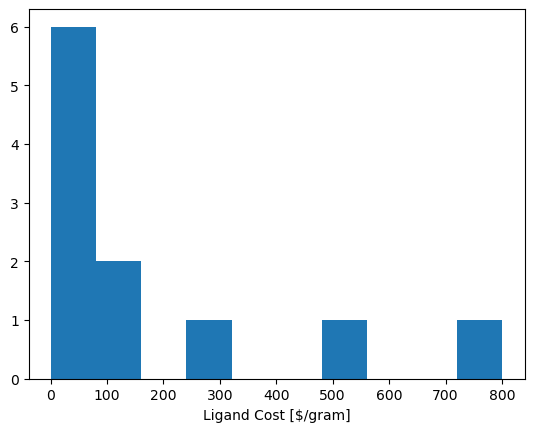

In [4]:
unique_ligands = np.unique(reaction_data.data["Ligand_Cost_fixed"].values)
unique_smiles = [
    reaction_data.data[reaction_data.data["Ligand_Cost_fixed"] == ligand][
        "Ligand_SMILES"
    ].values[0]
    for ligand in unique_ligands
]

print("There are", len(unique_ligands), "unique ligands in the dataset with costs ranging from", min(unique_ligands), "to", max(unique_ligands))

plt.hist(unique_ligands)
plt.xlabel("Ligand Cost [$/gram]")
plt.show()

Next, we visualize the ligands and their corresponding prices

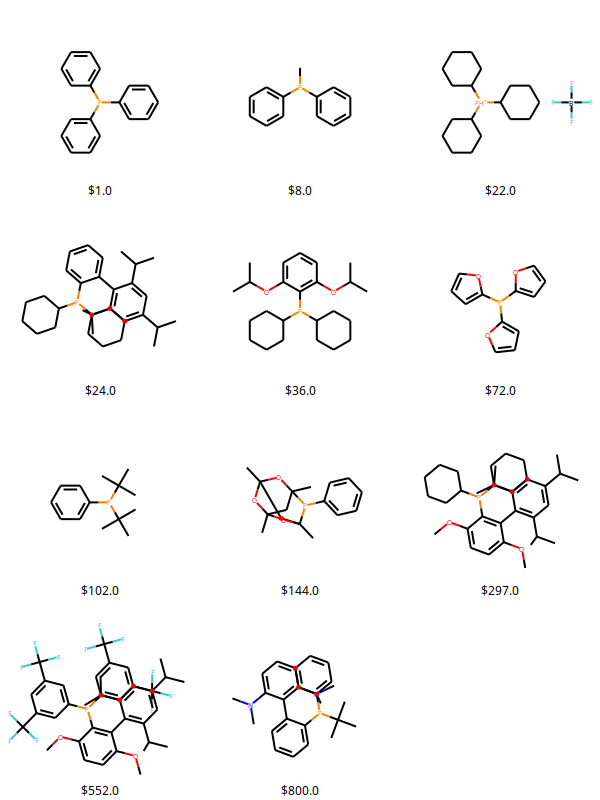

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor


# Generate molecules from SMILES and compute 2D coordinates
molecules = [Chem.MolFromSmiles(smiles) for smiles in unique_smiles]
for mol in molecules:
    rdDepictor.Compute2DCoords(mol)

# Create a dictionary of ligand prices and their corresponding molecules
ligand_dict = {f"${price}": mol for price, mol in zip(unique_ligands, molecules)}

# Draw the molecules with prices per gram as legends
img = Draw.MolsToGridImage(
    list(ligand_dict.values()), legends=list(ligand_dict.keys()), molsPerRow=3
)


img

Next we initialize the data with a random split between all measurements of the Direct Arylation dataset and featurize the datapoints via ECFP fingerprints and reaction conditions such as temperature and concentration. Finally, the feature vectors will be normalized to have a range of 0 to 1 in each dimension. 

In [5]:
DATASET = Evaluation_data(
    "BMS",
    300,
    "random",
    init_strategy="random",
)

DATASET.get_init_holdout_data(111)

(
    X_init,
    y_init,
    costs_init,
    X_candidate,
    y_candidate,
    costs_candidate,
) = DATASET.get_init_holdout_data(111)

Results from the GPR model
train size =  300
test size =  1428
r2 =  0.7783158019477012
N =  300 MAE =  7.379213318057834


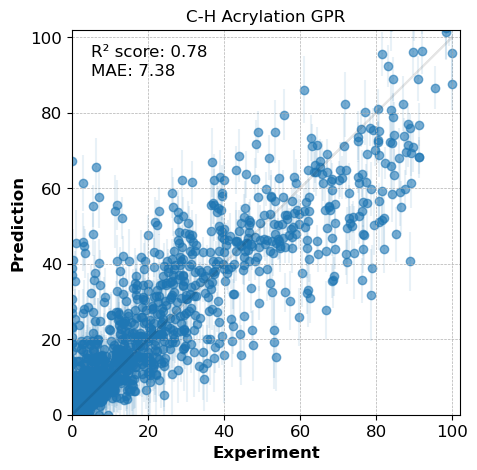

In [6]:
model, scaler_y = update_model(X_init, y_init,fit_y=False, bounds_norm=DATASET.bounds_norm, FIT_METHOD=True)


y_pred = model.posterior(X_candidate).mean.detach().flatten().numpy()
y_std = np.sqrt(model.posterior(X_candidate).variance.detach().flatten().numpy())

y_pred = y_pred.flatten()
y_candidate = y_candidate.flatten()


r2 = r2_score(y_candidate,y_pred)
mae = mean_absolute_error(y_candidate, y_pred)

print("Results from the GPR model")
print("train size = ", len(X_init))
print("test size = ", len(X_candidate))
print("r2 = ", r2)
print("N = ", len(X_init), "MAE = ", mae)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

dataset = "C-H Acrylation"


ax.set_title("{} GPR".format(dataset))
ax.errorbar(y_candidate, y_pred, yerr=y_std, marker=None, fmt=",", alpha=0.1)
ax.plot(y_candidate, y_candidate, color="black", alpha=0.1)
ax.scatter(y_candidate, y_pred, alpha=0.6)
# Setting the axis limits
ax.set_xlim(0, 102)
ax.set_ylim(0, 102)
ax.text(
    5, 95, f"R² score: {r2:.2f}", fontsize=12
)  # Adjust position and fontsize as needed
ax.text(5, 90, f"MAE: {mae:.2f}", fontsize=12)  # Adjust position and fontsize as needed
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Experiment", fontsize=12, fontweight="bold")
ax.set_ylabel("Prediction", fontsize=12, fontweight="bold")
plt.savefig(f"correlation_{dataset}_GPR.pdf")

However, in real experimental settings often only a few data points for a handful of ligands are availible. In the extremecase only a single ligand was investigated. Therefore we use a different initialization scheme in which only a single ligand was tested, here corresponding to the one with the worst yield across all reaction conditions corresponding to the `worst_ligand` flag.

In [7]:
DATASET = Evaluation_data(
    "BMS",
    200,
    "update_ligand_when_used",
    init_strategy="worst_ligand",
)


(
    X_init,
    y_init,
    costs_init,
    X_candidate,
    y_candidate,
    costs_candidate,
    LIGANDS_init,
    LIGANDS_candidate,
    price_dict,
    exp_init,
    exp_candidate,
) = DATASET.get_init_holdout_data(111)

`X_init` are the representation vectors of the initial experiments, and `y_init` are the corresponding yield measurements.

`costs_init` contains an array of all the costs for the ligands from the initially collected data.

`X_candidate` and `y_candidate` are the representation vectors and measurements of the holdout set, respectively.

`price_dict` is a dictionary of the current prices. Note that the initial ligand was already set to zero price as it was acquired beforehand.

`exp_init` and `exp_candidate` are the experimental conditions corresponding to their vectors `X_init` and `X_candidate`, respectively.

Next, we will show a simple example of how to perform Cost-informed Bayesian optimization with CIBO. First, we create a dictionary that covers all the parameters for the Bayesian optimization. We select the Direct Arylation dataset with the `BMS` keyword. As mentioned before, we start with the `worst_ligand` and set the `cost_aware` flag to `True`. Use `False` for normal BO.

To use the modified acquisition function as described in the paper, use the `minus` flag as well as the `NEI` acquisition function.


In [6]:
confs =[{
    "dataset": "BMS",
    "init_strategy": "worst_ligand",
    "cost_aware": True,
    "n_runs": 5,
    "n_iter": 12,
    "batch_size": 5,
    "ntrain": 200,
    "prices": "update_ligand_when_used",
    "surrogate": "GP",
    "acq_func": "NEI",
    "label": "BMS_COST_GP_NEI",
    "cost_mod": "minus",
},
{
    "dataset": "BMS",
    "init_strategy": "worst_ligand",
    "cost_aware": False,
    "n_runs": 5,
    "n_iter": 12,
    "batch_size": 5,
    "ntrain": 200,
    "prices": "update_ligand_when_used",
    "surrogate": "GP",
    "acq_func": "NEI",
    "label": "BMS_NORMAL_GP_NEI",
    "cost_mod": "minus",
}]


In the next cell we run the CIBO and BO after each other and same the results into the `RESULTS` dictionary

In [9]:
from cibo.utils import (
    create_aligned_transposed_price_table,
    data_dict_BO_LIGAND,
    data_dict_RS_LIGAND,
)
from cibo.experiments import (
    BO_LIGAND,
    BO_COI_LIGAND,
    RS_LIGAND,
)


RESULTS = {}

for conf in confs:

    print("Starting experiment: ", conf)
    y_better_BO_ALL, y_better_RANDOM_ALL = [], []
    running_costs_BO_ALL, running_costs_RANDOM_ALL = [], []

    DATASET = Evaluation_data(
        conf["dataset"],
        conf["ntrain"],
        conf["prices"],
        init_strategy=conf["init_strategy"],
    )
    bounds_norm = DATASET.bounds_norm
    N_RUNS = conf["n_runs"]
    NITER = conf["n_iter"]
    BATCH_SIZE = conf["batch_size"]
    SURROGATE = conf["surrogate"]
    COST_AWARE_BO = conf["cost_aware"]

    for run in range(N_RUNS):
        SEED = 111 + run
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)

        (
            X_init,
            y_init,
            costs_init,
            X_candidate,
            y_candidate,
            costs_candidate,
            LIGANDS_init,
            LIGANDS_candidate,
            price_dict,
            exp_init,
            exp_candidate,
        ) = DATASET.get_init_holdout_data(SEED)

        print(create_aligned_transposed_price_table(price_dict))
        X, y = cp.deepcopy(X_init), cp.deepcopy(y_init)
        y_best = float(torch.max(y))
        model, scaler_y = update_model(X, y, bounds_norm, surrogate=SURROGATE)
        X_candidate_FULL, y_candidate_FULL = cp.deepcopy(X_candidate), cp.deepcopy(
            y_candidate
        )
        X_candidate_BO = cp.deepcopy(X_candidate)
        y_candidate_BO = cp.deepcopy(y_candidate)
        exp_candidate_BO = cp.deepcopy(exp_candidate)


        y_candidate_RANDOM = cp.deepcopy(y_candidate).detach().numpy()
        exp_candidate_RANDOM = cp.deepcopy(exp_candidate)

        running_costs_BO = [0]
        running_costs_RANDOM = [0]

        price_dict_BO = cp.deepcopy(price_dict)
        price_dict_RANDOM = cp.deepcopy(price_dict)

        LIGANDS_candidate_BO = cp.deepcopy(LIGANDS_candidate)
        LIGANDS_candidate_RANDOM = cp.deepcopy(LIGANDS_candidate)

        y_better_BO = []
        y_better_RANDOM = []

        y_better_BO.append(y_best)
        y_better_RANDOM.append(y_best)
        y_best_BO, y_best_RANDOM = y_best, y_best

        BO_data = data_dict_BO_LIGAND(
            model,
            y_best_BO,
            scaler_y,
            X,
            y,
            X_candidate_BO,
            y_candidate_BO,
            LIGANDS_candidate_BO,
            y_better_BO,
            price_dict_BO,
            running_costs_BO,
            bounds_norm,
            BATCH_SIZE,
            None,
            SURROGATE,
            conf["acq_func"],
            exp_init,
            exp_candidate_BO,
        )

        BO_data["cost_mod"] = conf["cost_mod"]

        RANDOM_data = data_dict_RS_LIGAND(
            y_candidate_RANDOM,
            y_best_RANDOM,
            LIGANDS_candidate_RANDOM,
            price_dict_RANDOM,
            BATCH_SIZE,
            None,
            y_better_RANDOM,
            running_costs_RANDOM,
            exp_init,
            exp_candidate_RANDOM,
        )

        for i in range(NITER):
            if COST_AWARE_BO == False:
                BO_data = BO_LIGAND(BO_data)
            else:
                BO_data = BO_COI_LIGAND(BO_data)

            RANDOM_data = RS_LIGAND(RANDOM_data)

            print("--------------------")
            print(
                "# |{}/{}|\tBO {:.2f}\tRS {:.2f} \tSUM(COSTS BO): ${}\tSUM(COSTS RS): ${}\tN_train {}".format(
                    i + 1,
                    NITER,
                    BO_data["y_best_BO"],
                    RANDOM_data["y_best_RANDOM"],
                    BO_data["running_costs_BO"][-1],
                    RANDOM_data["running_costs_RANDOM"][-1],
                    BO_data["N_train"],
                )
            )
            print(create_aligned_transposed_price_table(price_dict_BO))

        y_better_BO_ALL.append(BO_data["y_better_BO"])
        y_better_RANDOM_ALL.append(RANDOM_data["y_better_RANDOM"])
        running_costs_BO_ALL.append(BO_data["running_costs_BO"])
        running_costs_RANDOM_ALL.append(RANDOM_data["running_costs_RANDOM"])

    y_better_BO_ALL = np.array(y_better_BO_ALL)
    y_better_RANDOM_ALL = np.array(y_better_RANDOM_ALL)


    if conf["cost_aware"] == True:
        RESULTS["CIBO"] = { "y_better": y_better_BO_ALL, "running_costs": running_costs_BO_ALL}
    else:
        RESULTS["BO"] = { "y_better": y_better_BO_ALL, "running_costs": running_costs_BO_ALL}
        RESULTS["RANDOM"] = { "y_better": y_better_RANDOM_ALL, "running_costs": running_costs_RANDOM_ALL}

Starting experiment:  {'dataset': 'BMS', 'init_strategy': 'worst_ligand', 'cost_aware': True, 'n_runs': 5, 'n_iter': 12, 'batch_size': 5, 'ntrain': 200, 'prices': 'update_ligand_when_used', 'surrogate': 'GP', 'acq_func': 'NEI', 'label': 'BMS_COST_GP_NEI', 'cost_mod': 'minus'}
Ligand 1  | Ligand 2  | Ligand 3  | Ligand 4  | Ligand 5  | Ligand 6  | Ligand 7  | Ligand 8  | Ligand 9  | Ligand 10 | Ligand 11 | Ligand 12
---------------------------------------------------------------------------------------------------------------------------------------------
22.0      | 102.0     | 36.0      | 24.0      | 144.0     | 800.0     | 297.0     | 552.0     | 0         | 8.0       | 1.0       | 72.0     
--------------------
# |1/12|	BO 89.71	RS 53.61 	SUM(COSTS BO): $9.0	SUM(COSTS RS): $427.0	N_train 149
Ligand 1  | Ligand 2  | Ligand 3  | Ligand 4  | Ligand 5  | Ligand 6  | Ligand 7  | Ligand 8  | Ligand 9  | Ligand 10 | Ligand 11 | Ligand 12
----------------------------------------------------

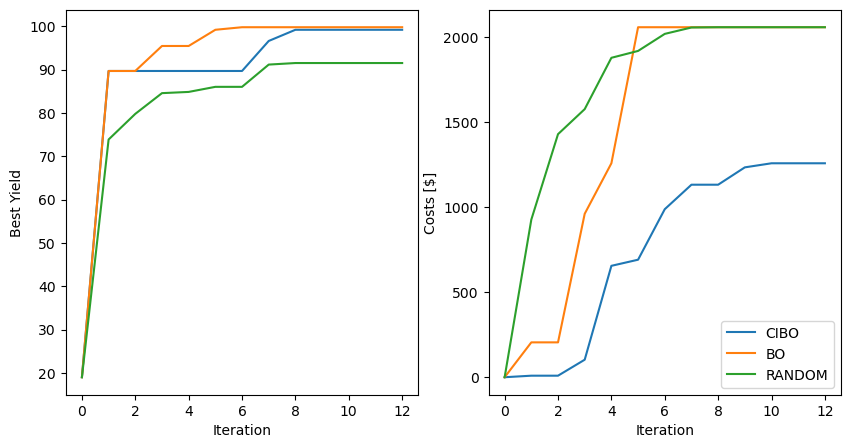

In [16]:
CIBO = np.mean(RESULTS["CIBO"]["y_better"], axis=0)
BO = np.mean(RESULTS["BO"]["y_better"], axis=0)

CIBO_COST = np.mean(RESULTS["CIBO"]["running_costs"], axis=0)
BO_COST = np.mean(RESULTS["BO"]["running_costs"], axis=0)


RANDOM = np.mean(y_better_RANDOM_ALL, axis=0)
RANDOM_COST = np.mean(running_costs_RANDOM_ALL, axis=0)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(CIBO, label="CIBO")
ax[0].plot(BO, label="BO")
ax[0].plot(RANDOM, label="RANDOM")


ax[1].plot(CIBO_COST, label="CIBO")
ax[1].plot(BO_COST, label="BO")
ax[1].plot(RANDOM_COST, label="RANDOM")




ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Best Yield")

ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Costs [$]")


plt.legend()
plt.show()

Now we discuss how to use the code for your own dataset! All that is needed is a CSV file with the following naming conventions for the columns

- As before `Ligand_Cost` is the cost per gram of each ligand

- `Base_SMILES`,`Ligand_SMILES` and `Solvent_SMILES` are the SMILES strings of basis, ligand and solvent respectively

- Finally, the `Concentration`, reaction temperature in degree celcius `Temp_C` and the yield `Yield`


In the next we show a chunk of such dataframe with the corresponding convention

In [11]:
data_dict = {
    "Ligand_Cost_fixed": [1.0, 552.0, 102.0],
    "Base_SMILES": [
        "CC(C)(C)C(=O)[O-].[K+]",
        "CC(C)(C)C(=O)[O-].[Cs+]",
        "CC(C)(C)C(=O)[O-].[K+]",
    ],
    "Ligand_SMILES": [
        "c1ccc(P(c2ccccc2)c2ccccc2)cc1",
        "COc1ccc(OC)c(P(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C",
        "CC(C)(C)P(c1ccccc1)C(C)(C)C",
    ],
    "Solvent_SMILES": ["Cc1ccc(C)cc1", "CC(=O)N(C)C", "Cc1ccc(C)cc1"],
    "Concentration": [0.1, 0.153, 0.1],
    "Temp_C": [105, 120, 90],
    "Yield": [1.41, 5.65, 0.0],
}

# Load the dictionary into a DataFrame
df = pd.DataFrame(data_dict)

# Display the DataFrame
print(df)

   Ligand_Cost_fixed              Base_SMILES  \
0                1.0   CC(C)(C)C(=O)[O-].[K+]   
1              552.0  CC(C)(C)C(=O)[O-].[Cs+]   
2              102.0   CC(C)(C)C(=O)[O-].[K+]   

                                       Ligand_SMILES Solvent_SMILES  \
0                      c1ccc(P(c2ccccc2)c2ccccc2)cc1   Cc1ccc(C)cc1   
1  COc1ccc(OC)c(P(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c2...    CC(=O)N(C)C   
2                        CC(C)(C)P(c1ccccc1)C(C)(C)C   Cc1ccc(C)cc1   

   Concentration  Temp_C  Yield  
0          0.100     105   1.41  
1          0.153     120   5.65  
2          0.100      90   0.00  


Next, we load the full dataframe. To bring your own data just change the `my_data_path` accordingly.

In [12]:
from cibo.data.datasets import user_data

#change the path to whereever you keep your data
my_data_path = "./cibo/data/user_data.csv"

user_data(csv_file=my_data_path)

However, the dataloader is actually much more flexible. To add an arbitrary number of compounds that are part of the reaction as well as numerical parameters, just follow the dictionary structure as shown here. In this example, we used the same dataset as before. The names of the columns can be adapted to the CSV file at hand.

In [13]:
from cibo.data.datasets import user_data

description = {
    "compounds": {
        "1": {"name": "Ligand_SMILES", "inp_type": "smiles"},
        "2": {"name": "Base_SMILES", "inp_type": "smiles"},
        "3": {"name": "Solvent_SMILES", "inp_type": "smiles"},
    },
    "parameters": {
        "1": {"name": "Concentration", "inp_type": "float"},
        "2": {"name": "Temp_C", "inp_type": "float"},
    },
    "cost": {"name": "Ligand_Cost_fixed", "inp_type": "float"},
    "target": {"name": "Yield", "inp_type": "float"},
}

data = user_data(csv_file=my_data_path, description=description)

Now we can visualize the space of reactions covered in this dataset with a `UMAP` projection.

2024-06-19 14:38:45.784185: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 14:38:45.785496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 14:38:45.805047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 14:38:46.222825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


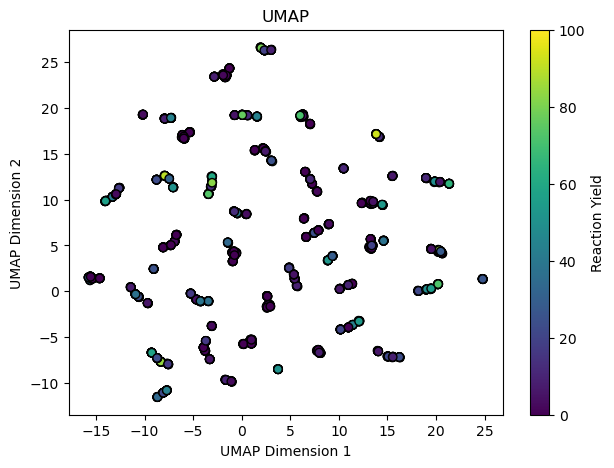

In [14]:
import umap
import matplotlib.pyplot as plt

# Assuming data.X and data.y are already defined
dimred = umap.UMAP(n_components=2, random_state=42)

X, y = data.X, data.y

X_umap = dimred.fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap="viridis", edgecolor="k")
ax.set_title("UMAP")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Reaction Yield")
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Assuming yield is in the range 0-100

plt.show()